## temp stats line plots

In [63]:
%reset
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/')
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS/')
import scendict as sc
import utils as ut
import netCDF4 as nc
import xarray as xr
import numpy as np
from importlib import reload
reload(sc)
reload(ut)

import cartopy as cp
import cartopy.crs as ccrs
import cmocean as cm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')
import glob
plt.rcParams.update({'font.size': 14})
font = {'family' : 'normal',
'weight' : 'bold',
'size'   : 14}

import time 
import pickle


import weighted
from matplotlib.cbook import violin_stats
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import numpy as np

Once deleted, variables cannot be recovered. Proceed (y/[n])?  y


In [64]:
def vdensity_with_weights(weights):
    ''' Outer function allows innder function access to weights. Matplotlib
    needs function to take in data and coords, so this seems like only way
    to 'pass' custom density function a set of weights '''
    
    def vdensity(data, coords):
        ''' Custom matplotlib weighted violin stats function '''
        # Using weights from closure, get KDE fomr statsmodels
        weighted_cost = sm.nonparametric.KDEUnivariate(data)
        weighted_cost.fit(fft=False, weights=weights)

        # Return y-values for graph of KDE by evaluating on coords
        return weighted_cost.evaluate(coords)
    return vdensity

def custom_violin_stats(data, weights):
    # Get weighted median and mean (using weighted module for median)
    median = weighted.quantile_1D(data, weights, 0.5)
    mean, sumw = np.ma.average(data, weights=list(weights), returned=True)
    
    # Use matplotlib violin_stats, which expects a function that takes in data and coords
    # which we get from closure above
    results = violin_stats(data, vdensity_with_weights(weights))
    
    # Update result dictionary with our updated info
    results[0][u"mean"] = mean
    results[0][u"median"] = median
    
    # No need to do this, since it should be populated from violin_stats
    # results[0][u"min"] =  np.min(data)
    # results[0][u"max"] =  np.max(data)

    return results

In [65]:
SIZE = 100
x = np.random.normal(size=SIZE)
w = np.random.randint(1, 10, size=SIZE) * 1.
w[30:50] =0

In [66]:
vpstats_1A = custom_violin_stats(x+0, w)
vpstats_1B = custom_violin_stats(x+1, w)
vpstats_2A = custom_violin_stats(x+2, w)
vpstats_2B = custom_violin_stats(x+3, w)
vpstats_3A = custom_violin_stats(x+4, w)
vpstats_3B = custom_violin_stats(x+5, w)

[Text(0, 1.0, '1A: Nat. Ozone \n (SSP1-2.6)'),
 Text(0, 1.75, '1B: Nat. Ozone \n (SSP3-7.0)'),
 Text(0, 3.0, '2A: Ozone 1950 \n (SSP1-2.6)'),
 Text(0, 3.75, '2B: Ozone 1950 \n (SSP3-7.0)'),
 Text(0, 5.0, '3A: Ozone 1990 \n (SSP1-2.6)'),
 Text(0, 5.75, '3B: Ozone 1990 \n (SSP3-7.0)')]

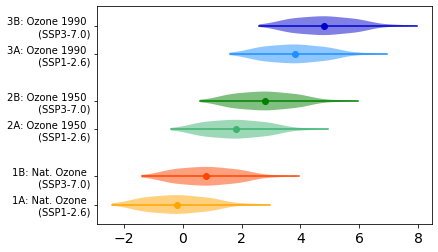

In [67]:
scens = ['1A','1B','2A','2B','3A','3B']
vpstats = [vpstats_1A,vpstats_1B,vpstats_2A,\
           vpstats_2B,vpstats_3A,vpstats_3B]
plcs = [[1],[1.75],[3],[3.75],[5],[5.75]]

fig, ax = plt.subplots()
for i in range(0,6):
    vpst = vpstats[i]
    plc = plcs[i]
    vplot = ax.violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                      showmedians=False)
    ax.plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'])
    ax.plot([(vpst[0]['min']),(vpst[0]['max'])],[plc,plc], linestyle = '-',\
           color = sc.scen[scens[i]]['color'])
    for pc in vplot['bodies']:
        pc.set_facecolor(sc.scen[scens[i]]['color'])
        pc.set_alpha(0.5)

ax.set_yticks([1,1.75,3,3.75,5,5.75])
ax.set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
                    '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
                    '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
                  fontsize = 10)
# vplot = ax.violin(vpstats, [4], vert=False, showmeans=True, showextrema=True,
#                   showmedians=False)
# for pc in vplot['bodies']:
#     pc.set_facecolor('turquoise')
#     pc.set_alpha(0.8)

In [68]:
scen = '1A'
tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_airtemp.nc'
q = xr.open_dataset(tw)
print(q)

<xarray.Dataset>
Dimensions:    (mon: 15, x: 182, y: 149, yr: 161)
Coordinates:
  * yr         (yr) int64 1940 1941 1942 1943 1944 ... 2096 2097 2098 2099 2100
  * mon        (mon) int64 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15
  * x          (x) int64 0 1 2 3 4 5 6 7 8 ... 174 175 176 177 178 179 180 181
  * y          (y) int64 0 1 2 3 4 5 6 7 8 ... 141 142 143 144 145 146 147 148
Data variables:
    mean_tair  (yr, mon, y, x) float64 ...
Attributes:
    desc:     mean monthly maps of temp, made from ~/scratch/MET_forcing/
    desc2:    summer is month 13, winter is month 14, full year is month 15 (...


In [69]:
tmesh = xr.open_dataset('/gpfs/data/greenocean/software/resources/regrid/mesh_mask3_6.nc')
tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
test_csize = tmesh.csize[0:37,:].values

def make_vpstats(scen,season,yrst,yrend):

    tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_airtemp.nc'
    q = xr.open_dataset(tw)
    test_wspd = np.nanmean(q.mean_tair[yrst:yrend,season,0:37,:].values-273, axis = 0)
    vpstats = custom_violin_stats(np.ravel(test_wspd), np.ravel(test_csize))
    
    return vpstats

In [70]:
import time
ts = time.time()
#12 is summer, 13 is winter
vpstats_1A_s_1950 = make_vpstats('1A',12,0,20)
vpstats_1B_s_1950 = make_vpstats('1B',12,0,20)
vpstats_2A_s_1950 = make_vpstats('2A',12,0,20)
vpstats_2B_s_1950 = make_vpstats('2B',12,0,20)
vpstats_3A_s_1950 = make_vpstats('3A',12,0,20)
vpstats_3B_s_1950 = make_vpstats('3B',12,0,20)
##
vpstats_1A_w_1950 = make_vpstats('1A',13,0,20)
vpstats_1B_w_1950 = make_vpstats('1B',13,0,20)
vpstats_2A_w_1950 = make_vpstats('2A',13,0,20)
vpstats_2B_w_1950 = make_vpstats('2B',13,0,20)
vpstats_3A_w_1950 = make_vpstats('3A',13,0,20)
vpstats_3B_w_1950 = make_vpstats('3B',13,0,20)

#12 is summer, 13 is winter
vpstats_1A_s_2020 = make_vpstats('1A',12,70,90)
vpstats_1B_s_2020 = make_vpstats('1B',12,70,90)
vpstats_2A_s_2020 = make_vpstats('2A',12,70,90)
vpstats_2B_s_2020 = make_vpstats('2B',12,70,90)
vpstats_3A_s_2020 = make_vpstats('3A',12,70,90)
vpstats_3B_s_2020 = make_vpstats('3B',12,70,90)
##
vpstats_1A_w_2020 = make_vpstats('1A',13,70,90)
vpstats_1B_w_2020 = make_vpstats('1B',13,70,90)
vpstats_2A_w_2020 = make_vpstats('2A',13,70,90)
vpstats_2B_w_2020 = make_vpstats('2B',13,70,90)
vpstats_3A_w_2020 = make_vpstats('3A',13,70,90)
vpstats_3B_w_2020 = make_vpstats('3B',13,70,90)
##
#12 is summer, 13 is winter
vpstats_1A_s_2050 = make_vpstats('1A',12,100,120)
vpstats_1B_s_2050 = make_vpstats('1B',12,100,120)
vpstats_2A_s_2050 = make_vpstats('2A',12,100,120)
vpstats_2B_s_2050 = make_vpstats('2B',12,100,120)
vpstats_3A_s_2050 = make_vpstats('3A',12,100,120)
vpstats_3B_s_2050 = make_vpstats('3B',12,100,120)
##
vpstats_1A_w_2050 = make_vpstats('1A',13,100,120)
vpstats_1B_w_2050 = make_vpstats('1B',13,100,120)
vpstats_2A_w_2050 = make_vpstats('2A',13,100,120)
vpstats_2B_w_2050 = make_vpstats('2B',13,100,120)
vpstats_3A_w_2050 = make_vpstats('3A',13,100,120)
vpstats_3B_w_2050 = make_vpstats('3B',13,100,120)

#12 is summer, 13 is winter
vpstats_1A_s_2090 = make_vpstats('1A',12,140,160)
vpstats_1B_s_2090 = make_vpstats('1B',12,140,160)
vpstats_2A_s_2090 = make_vpstats('2A',12,140,160)
vpstats_2B_s_2090 = make_vpstats('2B',12,140,160)
vpstats_3A_s_2090 = make_vpstats('3A',12,140,160)
vpstats_3B_s_2090 = make_vpstats('3B',12,140,160)
##
vpstats_1A_w_2090 = make_vpstats('1A',13,140,160)
vpstats_1B_w_2090 = make_vpstats('1B',13,140,160)
vpstats_2A_w_2090 = make_vpstats('2A',13,140,160)
vpstats_2B_w_2090 = make_vpstats('2B',13,140,160)
vpstats_3A_w_2090 = make_vpstats('3A',13,140,160)
vpstats_3B_w_2090 = make_vpstats('3B',13,140,160)

te = time.time()
print(te-ts)

191.51172018051147


In [71]:
pdir = '/gpfs/home/mep22dku/scratch/SOZONE/PICTURES/CELOS2022/'

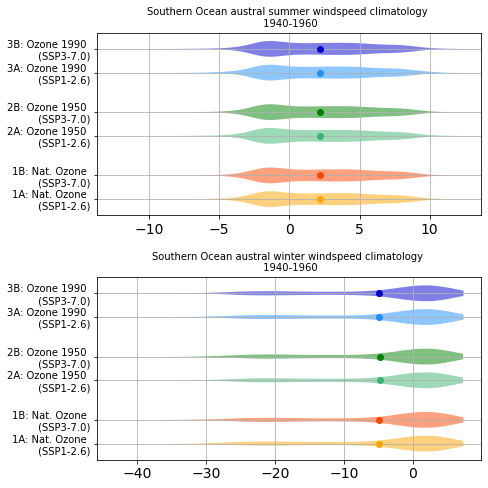

In [72]:
scens = ['1A','1B','2A','2B','3A','3B']
vpstats_1950_s = [vpstats_1A_s_1950,vpstats_1B_s_1950,vpstats_2A_s_1950,\
           vpstats_2B_s_1950,vpstats_3A_s_1950,vpstats_3B_s_1950]

vpstats_1950_w = [vpstats_1A_w_1950,vpstats_1B_w_1950,vpstats_2A_w_1950,\
           vpstats_2B_w_1950,vpstats_3A_w_1950,vpstats_3B_w_1950]

vpstats_2090_s = [vpstats_1A_s_2090,vpstats_1B_s_2090,vpstats_2A_s_2090,\
           vpstats_2B_s_2090,vpstats_3A_s_2090,vpstats_3B_s_2090]

vpstats_2090_w = [vpstats_1A_w_2090,vpstats_1B_w_2090,vpstats_2A_w_2090,\
           vpstats_2B_w_2090,vpstats_3A_w_2090,vpstats_3B_w_2090]

plcs = [[1],[1.75],[3],[3.75],[5],[5.75]]

fact = 0.5
fig, axs = plt.subplots(2,1, figsize=(14*fact, 14*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for i in range(0,6):

    plc = plcs[i]
    vpst = vpstats_1950_s[i]
    vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                      showmedians=False)
    axs[0].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'])
    for pc in vplot['bodies']:
        pc.set_facecolor(sc.scen[scens[i]]['color'])
        pc.set_alpha(0.5)

    vpst = vpstats_1950_w[i]
    vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                      showmedians=False)
    axs[1].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'])
    for pc in vplot['bodies']:
        pc.set_facecolor(sc.scen[scens[i]]['color'])
        # pc.set_edgecolor('k')
        pc.set_alpha(0.5)

for i in range(0,2):        
    axs[i].set_yticks([1,1.75,3,3.75,5,5.75])
    axs[i].set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
                        '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
                        '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
                      fontsize = 10)
    axs[i].grid()
    #axs[i].set_xlim([3,12])
    #axs[i].set_xticks(np.arange(3,13,1))
    #axs[i].set_xticklabels(np.arange(3,13,1), fontsize = 10)
    axs[0].set_title('Southern Ocean austral summer windspeed climatology \n 1940-1960', fontsize = 10)
    axs[1].set_title('Southern Ocean austral winter windspeed climatology \n 1940-1960', fontsize = 10)
plt.tight_layout()

In [73]:
vpstats_1950_s = [vpstats_1A_s_1950,vpstats_1B_s_1950,vpstats_2A_s_1950,\
           vpstats_2B_s_1950,vpstats_3A_s_1950,vpstats_3B_s_1950]

vpstats_1950_w = [vpstats_1A_w_1950,vpstats_1B_w_1950,vpstats_2A_w_1950,\
           vpstats_2B_w_1950,vpstats_3A_w_1950,vpstats_3B_w_1950]

vpstats_2090_s = [vpstats_1A_s_2090,vpstats_1B_s_2090,vpstats_2A_s_2090,\
           vpstats_2B_s_2090,vpstats_3A_s_2090,vpstats_3B_s_2090]

vpstats_2090_w = [vpstats_1A_w_2090,vpstats_1B_w_2090,vpstats_2A_w_2090,\
           vpstats_2B_w_2090,vpstats_3A_w_2090,vpstats_3B_w_2090]

vpstats_2020_s = [vpstats_1A_s_2020,vpstats_1B_s_2020,vpstats_2A_s_2020,\
           vpstats_2B_s_2020,vpstats_3A_s_2020,vpstats_3B_s_2020]

vpstats_2020_w = [vpstats_1A_w_2020,vpstats_1B_w_2020,vpstats_2A_w_2020,\
           vpstats_2B_w_2020,vpstats_3A_w_2020,vpstats_3B_w_2020]

vpstats_2050_s = [vpstats_1A_s_2050,vpstats_1B_s_2050,vpstats_2A_s_2050,\
           vpstats_2B_s_2050,vpstats_3A_s_2050,vpstats_3B_s_2050]

vpstats_2050_w = [vpstats_1A_w_2050,vpstats_1B_w_2050,vpstats_2A_w_2050,\
           vpstats_2B_w_2050,vpstats_3A_w_2050,vpstats_3B_w_2050]

In [74]:
def paganini(sum_plot_f, win_plot_f, tim, ghost = True):
    scens = ['1A','1B','2A','2B','3A','3B']
    plcs = [[1],[1.75],[3],[3.75],[5],[5.75]]

    fact = 0.5
    fig, axs = plt.subplots(2,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
    axs = axs.ravel()

    sum_plot = vpstats_1950_s
    win_plot = vpstats_1950_w

    for i in range(0,6):
        ### 1950s
        if ghost:
            plc = plcs[i]
            vpst = sum_plot[i]
            vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                              showmedians=False)
            axs[0].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')
            for pc in vplot['bodies']:
                pc.set_facecolor('grey')
                pc.set_alpha(0.5)
                pc.set_edgecolor('grey')
                

            vpst = win_plot[i]
            vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                              showmedians=False)
            axs[1].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')

            # ax.plot([(vpst[0]['min']),(vpst[0]['max'])],[plc,plc], linestyle = '-',\
            #        color = sc.scen[scens[i]]['color'])
            for pc in vplot['bodies']:
                pc.set_facecolor('grey')
                pc.set_alpha(0.5)
                pc.set_edgecolor('grey')
                

    ##2090s
        plc = plcs[i]
        vpst = sum_plot_f[i]
        vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                          showmedians=False)
        axs[0].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'], markeredgecolor = 'k')
        for pc in vplot['bodies']:
            pc.set_facecolor(sc.scen[scens[i]]['color'])
            pc.set_edgecolor(sc.scen[scens[i]]['color'])
            pc.set_alpha(0.5)

        vpst = win_plot_f[i]
        vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                          showmedians=False)
        axs[1].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'], markeredgecolor = 'k')
        for pc in vplot['bodies']:
            pc.set_facecolor(sc.scen[scens[i]]['color'])
            pc.set_edgecolor(sc.scen[scens[i]]['color'])
            pc.set_alpha(0.5)

    for i in range(0,2):        
        axs[i].set_yticks([1,1.75,3,3.75,5,5.75])
        axs[i].set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
                            '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
                            '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
                          fontsize = 10)
        axs[i].grid()
        # axs[i].set_xlim([3,12])
        # axs[i].set_xticks(np.arange(3,13,1))
        # axs[i].set_xticklabels(np.arange(3,13,1), fontsize = 10)
        axs[0].set_title(f'Austral Summer', fontsize = 12)
        axs[1].set_title(f'Austral Winter', fontsize = 12)
        axs[0].set_xlabel('m s$^{-1}$', fontsize = 10)
        axs[1].set_xlabel('m s$^{-1}$', fontsize = 10)
    plt.tight_layout()
    fig.savefig(f'{pdir}/airtemp_{tim}.jpg', dpi = 250)

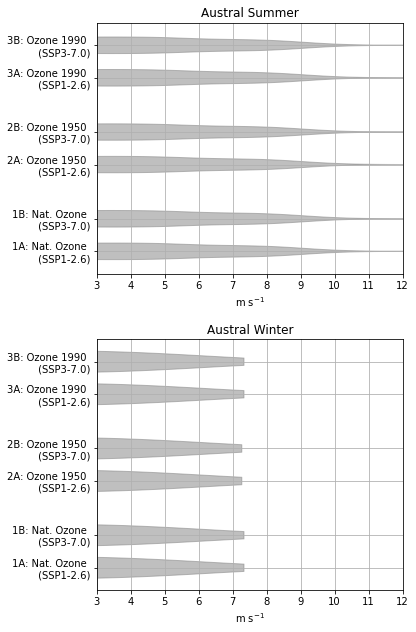

In [75]:
scens = ['1A','1B','2A','2B','3A','3B']
plcs = [[1],[1.75],[3],[3.75],[5],[5.75]]

fact = 0.5
fig, axs = plt.subplots(2,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

sum_plot = vpstats_1950_s
win_plot = vpstats_1950_w
ghost = True
for i in range(0,6):
    ### 1950s
    if ghost:
        plc = plcs[i]
        vpst = sum_plot[i]
        vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                          showmedians=False)
        axs[0].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')
        for pc in vplot['bodies']:
            pc.set_facecolor('grey')
            pc.set_alpha(0.5)
            pc.set_edgecolor('grey')


        vpst = win_plot[i]
        vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                          showmedians=False)
        axs[1].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')

        # ax.plot([(vpst[0]['min']),(vpst[0]['max'])],[plc,plc], linestyle = '-',\
        #        color = sc.scen[scens[i]]['color'])
        for pc in vplot['bodies']:
            pc.set_facecolor('grey')
            pc.set_alpha(0.5)
            pc.set_edgecolor('grey')

for i in range(0,2):        
    axs[i].set_yticks([1,1.75,3,3.75,5,5.75])
    axs[i].set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
                        '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
                        '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
                      fontsize = 10)
    axs[i].grid()
    axs[i].set_xlim([3,12])
    axs[i].set_xticks(np.arange(3,13,1))
    axs[i].set_xticklabels(np.arange(3,13,1), fontsize = 10)
    axs[0].set_title(f'Austral Summer', fontsize = 12)
    axs[1].set_title(f'Austral Winter', fontsize = 12)
    axs[0].set_xlabel('m s$^{-1}$', fontsize = 10)
    axs[1].set_xlabel('m s$^{-1}$', fontsize = 10)
plt.tight_layout()
fig.savefig(f'{pdir}/temp_BW_BASELINE.jpg', dpi = 250)

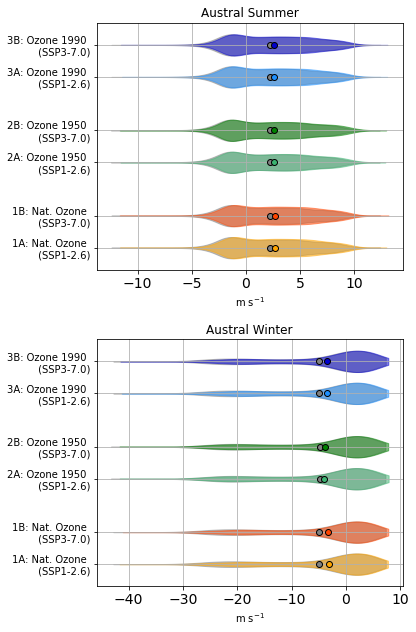

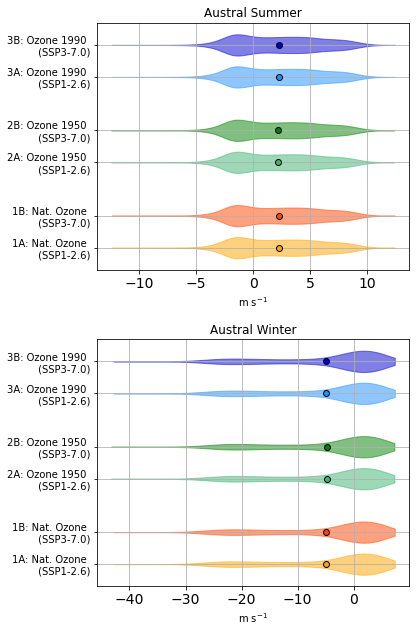

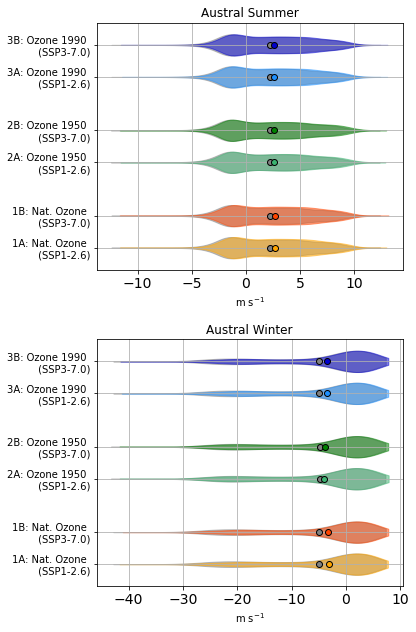

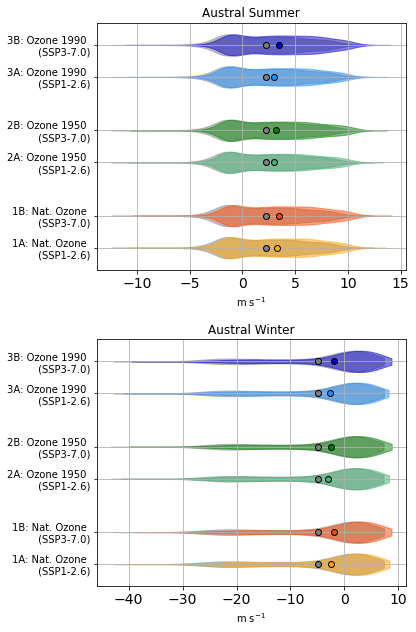

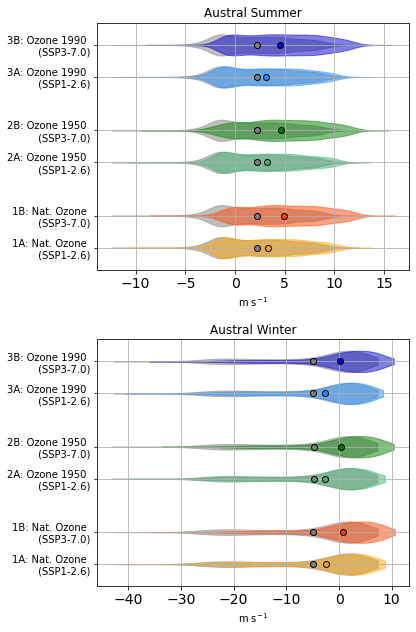

In [76]:
sum_plot_f = vpstats_2020_s
win_plot_f = vpstats_2020_w
tim = '2010-2030'
paganini(sum_plot_f, win_plot_f, tim, ghost = True)

sum_plot_f = vpstats_1950_s
win_plot_f = vpstats_1950_w
tim = '1940-1960'
paganini(sum_plot_f, win_plot_f, tim, ghost = False)

sum_plot_f = vpstats_2020_s
win_plot_f = vpstats_2020_w
tim = '2010-2030'
paganini(sum_plot_f, win_plot_f, tim, ghost = True)

sum_plot_f = vpstats_2050_s
win_plot_f = vpstats_2050_w
tim = '2040-2060'
paganini(sum_plot_f, win_plot_f, tim, ghost = True)

sum_plot_f = vpstats_2090_s
win_plot_f = vpstats_2090_w
tim = '2080-2100'
paganini(sum_plot_f, win_plot_f, tim, ghost = True)

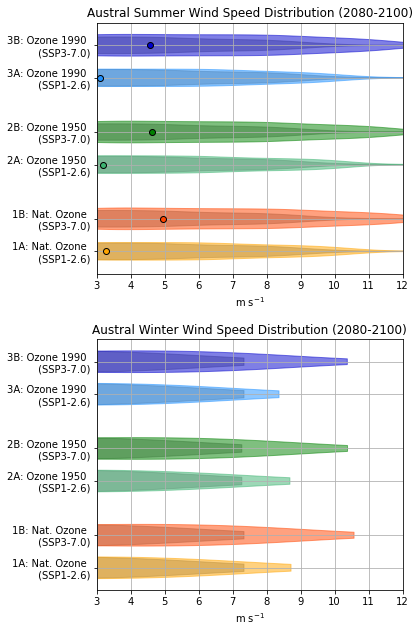

In [77]:
ghost = True
sum_plot_f = vpstats_2090_s
win_plot_f = vpstats_2090_w
tim = '2080-2100'
scens = ['1A','1B','2A','2B','3A','3B']
plcs = [[1],[1.75],[3],[3.75],[5],[5.75]]

fact = 0.5
fig, axs = plt.subplots(2,1, figsize=(12*fact, 18*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

sum_plot = vpstats_1950_s
win_plot = vpstats_1950_w

for i in range(0,6):
    ### 1950s
    if ghost:
        plc = plcs[i]
        vpst = sum_plot[i]
        vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                          showmedians=False)
        axs[0].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')
        for pc in vplot['bodies']:
            pc.set_facecolor('grey')
            pc.set_alpha(0.5)
            pc.set_edgecolor('grey')


        vpst = win_plot[i]
        vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                          showmedians=False)
        axs[1].plot((vpst[0]['mean']),plc, marker = 'o', markerfacecolor = 'grey', markeredgecolor = 'k')

        # ax.plot([(vpst[0]['min']),(vpst[0]['max'])],[plc,plc], linestyle = '-',\
        #        color = sc.scen[scens[i]]['color'])
        for pc in vplot['bodies']:
            pc.set_facecolor('grey')
            pc.set_alpha(0.5)
            pc.set_edgecolor('grey')


##2090s
    plc = plcs[i]
    vpst = sum_plot_f[i]
    vplot = axs[0].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                      showmedians=False)
    axs[0].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'], markeredgecolor = 'k')
    for pc in vplot['bodies']:
        pc.set_facecolor(sc.scen[scens[i]]['color'])
        pc.set_edgecolor(sc.scen[scens[i]]['color'])
        pc.set_alpha(0.5)

    vpst = win_plot_f[i]
    vplot = axs[1].violin(vpst, plc, vert=False, showmeans=False, showextrema=False,
                      showmedians=False)
    axs[1].plot((vpst[0]['mean']),plc, marker = 'o', color = sc.scen[scens[i]]['color'], markeredgecolor = 'k')
    for pc in vplot['bodies']:
        pc.set_facecolor(sc.scen[scens[i]]['color'])
        pc.set_edgecolor(sc.scen[scens[i]]['color'])
        pc.set_alpha(0.5)

for i in range(0,2):        
    axs[i].set_yticks([1,1.75,3,3.75,5,5.75])
    axs[i].set_yticklabels(['1A: Nat. Ozone \n (SSP1-2.6)','1B: Nat. Ozone \n (SSP3-7.0)',
                        '2A: Ozone 1950 \n (SSP1-2.6)','2B: Ozone 1950 \n (SSP3-7.0)',
                        '3A: Ozone 1990 \n (SSP1-2.6)','3B: Ozone 1990 \n (SSP3-7.0)'], \
                      fontsize = 10)
    axs[i].grid()
    axs[i].set_xlim([3,12])
    axs[i].set_xticks(np.arange(3,13,1))
    axs[i].set_xticklabels(np.arange(3,13,1), fontsize = 10)
    axs[0].set_title(f'Austral Summer Wind Speed Distribution (2080-2100)', fontsize = 12)
    axs[1].set_title(f'Austral Winter Wind Speed Distribution (2080-2100)', fontsize = 12)
    axs[0].set_xlabel('m s$^{-1}$', fontsize = 10)
    axs[1].set_xlabel('m s$^{-1}$', fontsize = 10)
plt.tight_layout()
fig.savefig(f'{pdir}/temp_annot_{tim}.jpg', dpi = 250)

In [78]:
def get_means(scen):
    tw = f'/gpfs/home/mep22dku/scratch/SOZONE/MO_pipeline/EXTRACT/ncs/scen_{scen}_monthly_airtemp.nc'
    tmesh['csize'] = tmesh.tmask[0,0,:,:] * tmesh.e1t[0,:,:] * tmesh.e2t[0,:,:]
    test_csize = tmesh.csize[0:37,:].values
    tweights = np.ravel(test_csize)
    q = xr.open_dataset(tw)
    tscen = np.zeros([2,161])
    for i in range(0,161):
        test_wspd = (q.mean_tair[i,12,0:37,:].values-273.15)
        data = np.ravel(test_wspd)

        mean, sumw = np.ma.average(data, weights=list(tweights), returned=True)
        tscen[0,i] = mean
        test_wspd = (q.mean_tair[i,13,0:37,:].values-273.15)
        data = np.ravel(test_wspd)
        mean, sumw = np.ma.average(data, weights=list(tweights), returned=True)
        tscen[1,i] = mean

    return tscen

In [79]:
ar_1A = get_means('1A')
ar_1B = get_means('1B')
ar_2A = get_means('2A')
ar_2B = get_means('2B')
ar_3A = get_means('3A')
ar_3B = get_means('3B')

In [80]:

def moving_average(x, w):
    return np.convolve(x, np.ones(w), 'valid') / w


ar_1A_mv = moving_average(ar_1A[0,:],10)
np.shape(ar_1A_mv)

(152,)

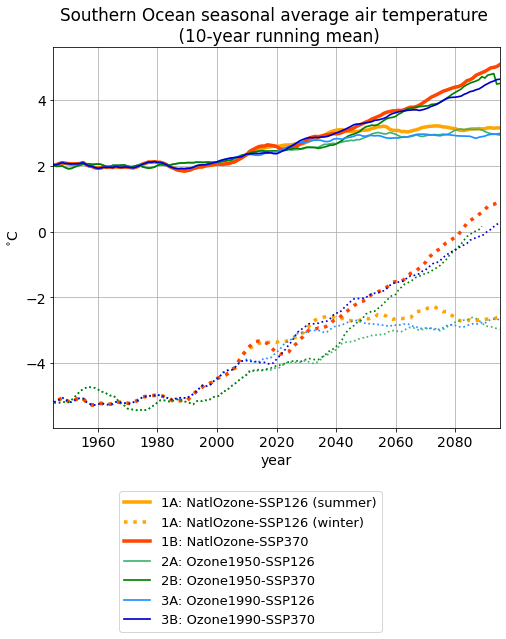

In [81]:
scens = ['1A','1B','2A','2B','3A','3B']
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]
## rude patch
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]
ar_1A[:,30]=ar_1A[:,29];
ar_1B[:,30]=ar_1B[:,29];
ar_2A[:,41]=ar_2A[:,40];
ar_2B[:,41]=ar_2B[:,40];
ar_2B[:,142]=ar_2B[:,141];
ar_3A[:,30]=ar_3A[:,29];
ar_3B[:,30]=ar_3B[:,29];

labs_s = ['1A: NatlOzone-SSP126 (winter)', '1B: NatlOzone-SSP370', '2A: Ozone1950-SSP126', '2B: Ozone1950-SSP370', '3A: Ozone1990-SSP126', '3B: Ozone1990-SSP370']
labs_w = ['1A: NatlOzone-SSP126 (winter)', '1B: NatlOzone-SSP370', '2A: Ozone1950-SSP126', '2B: Ozone1950-SSP370', '3A: Ozone1990-SSP126', '3B: Ozone1990-SSP370']

#

fact = 0.5
fig, axs = plt.subplots(1,1, figsize=(16*fact, 14*fact), facecolor='w', edgecolor='k')
# axs = axs.ravel()
for i in range(0,6):
    if i <2:
        lw = 3.5
    else:
        lw = 1.7
    
    if i == 0:
        tplt = scen_ars[i][0,:]
        tnam = sc.scen[scens[i]]['name']
        tlab = f'{tnam} (summer)'
        axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = '-',\
                label = tlab)

        tplt = scen_ars[i][1,:]
        tnam = sc.scen[scens[i]]['name']
        axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = ':',\
                label = f'{tnam} (winter)')
    else:
        tplt = scen_ars[i][0,:]
        tnam = sc.scen[scens[i]]['name']
        tlab = f'{tnam}'
        axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = '-',\
                label = tlab)
        tplt = scen_ars[i][1,:]
        tnam = sc.scen[scens[i]]['name']
        tlab = f'{tnam}'
        axs.plot(np.arange(1944,2096,1),moving_average(tplt,10),\
                 color = sc.scen[scens[i]]['color'], linewidth = lw, linestyle = ':',\
               )


    axs.legend(ncol = 1, bbox_to_anchor = [0.75,-0.15], fontsize = 13)

axs.grid()
axs.set_xlim(1945,2095)
axs.set_ylabel('$^{\circ}$C')
axs.set_xlabel('year')
axs.set_title('Southern Ocean seasonal average air temperature \n (10-year running mean)')
fig.savefig(f'{pdir}/temp_10yrmean.jpg', dpi = 250)

In [82]:
labs = []
for i in range(0,6):
    tnam = sc.scen[scens[i]]['name']
    labs.append(tnam)
    
print(labs)

['1A: NatlOzone-SSP126', '1B: NatlOzone-SSP370', '2A: Ozone1950-SSP126', '2B: Ozone1950-SSP370', '3A: Ozone1990-SSP126', '3B: Ozone1990-SSP370']


(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)
(array([], dtype=int64),)


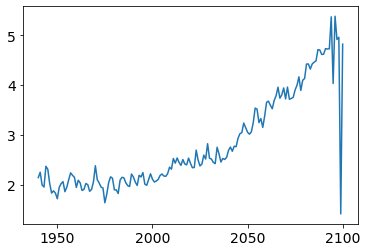

In [83]:
# plt.plot(np.arange(1940,2101,1),ar_1B[0,:])
plt.plot(np.arange(1940,2101,1),ar_2B[0,:])
scen_ars = [ar_1A,ar_1B,ar_2A,ar_2B,ar_3A,ar_3B]
ar_1A[:,30]=ar_1A[:,29];
ar_1B[:,30]=ar_1B[:,29];
ar_2A[:,41]=ar_2A[:,40];
ar_2B[:,41]=ar_2B[:,40];
ar_2B[:,142]=ar_2B[:,141];
ar_3A[:,30]=ar_3A[:,29];
ar_3B[:,30]=ar_3B[:,29];
for i in range(0,6):
    print(np.where(np.isnan(scen_ars[i][0,:])))